In [186]:
import condastats
from condastats.cli import overall, pkg_platform, pkg_version, pkg_python, data_source
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Output Conda Forge package downloads for some IOOS Python packages 

Statistics for Conda Forge package downloads are available since 2017-01.  More info on the condastats package and compiled statistics available [here](https://www.anaconda.com/blog/get-python-package-download-statistics-with-condastats).

Below, we run the package to gather cumulative downloads for some popular IOOS Python packages since then.  Note: some packaes have only been published very recently (ioos_qc), so side by side comparison for the entire time period is skewed.

#### Try a few using the command line approach:

In [5]:
!condastats overall --start_month 2017-01 compliance-checker pyoos erddapy ioos_qc sensorml2iso

pkg_name
compliance-checker    79102
pyoos                 16491
sensorml2iso           8580
erddapy                6867
ioos_qc                1036
Name: counts, dtype: int64


What about statistics for 2020 only? 

Note: it's necessary to specify both --start_month and --end_month in order to perform a proper filter (otherwise, will return all the months results).

In [91]:
!condastats overall --start_month 2020-01 --end_month 2020-06 compliance-checker pyoos erddapy ioos_qc sensorml2iso

pkg_name
compliance-checker    21432
sensorml2iso           2351
erddapy                1370
pyoos                  4082
ioos_qc                 625
Name: counts, dtype: int64


2019:

In [90]:
!condastats overall --start_month 2019-01 --end_month 2019-12 compliance-checker pyoos erddapy ioos_qc sensorml2iso

pkg_name
compliance-checker    17376
erddapy                2431
sensorml2iso           1830
pyoos                  3123
ioos_qc                 411
Name: counts, dtype: int64


#### Use the Python API and Pandas to get a little more info

We can break out and generate some plots by month by passing 'monthly=True' 

In [137]:
df = overall(['compliance-checker', 'pyoos', 'erddapy', 'ioos_qc', 'sensorml2iso'], start_month='2017-01', monthly=True).to_frame()
df.head()

counts
pkg_name           time           
compliance-checker 2017-03   100.0
                   2017-04   884.0
                   2017-05  1274.0
                   2017-06   706.0
                   2017-07  1131.0

The DataFrame returned uses a MultiIndex with level=0 for the package and level=1 for the 'time' index. 

In [139]:
df.index

MultiIndex([('compliance-checker', '2017-03'),
            ('compliance-checker', '2017-04'),
            ('compliance-checker', '2017-05'),
            ('compliance-checker', '2017-06'),
            ('compliance-checker', '2017-07'),
            ('compliance-checker', '2017-08'),
            ('compliance-checker', '2017-09'),
            ('compliance-checker', '2017-10'),
            ('compliance-checker', '2017-11'),
            ('compliance-checker', '2017-12'),
            ...
            (           'ioos_qc', '2019-09'),
            (           'ioos_qc', '2019-10'),
            (           'ioos_qc', '2019-11'),
            (           'ioos_qc', '2019-12'),
            (           'ioos_qc', '2020-01'),
            (           'ioos_qc', '2020-02'),
            (           'ioos_qc', '2020-03'),
            (           'ioos_qc', '2020-04'),
            (           'ioos_qc', '2020-05'),
            (           'ioos_qc', '2020-06')],
           names=['pkg_name', 'time'], leng

The 'time' index is not datetime64 type, however:

In [156]:
df.index.get_level_values(level='time')
#df_recent.index.get_level_values(level='pkg_name')

DatetimeIndex(['2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='time', length=167, freq=None)

Use set_index() to create a DateTimeIndex for the level='time' index:

In [141]:
df = df.set_index([df.index.get_level_values(level='pkg_name'), pd.to_datetime(df.index.get_level_values(level='time'))])
df.index

MultiIndex([('compliance-checker', '2017-03-01'),
            ('compliance-checker', '2017-04-01'),
            ('compliance-checker', '2017-05-01'),
            ('compliance-checker', '2017-06-01'),
            ('compliance-checker', '2017-07-01'),
            ('compliance-checker', '2017-08-01'),
            ('compliance-checker', '2017-09-01'),
            ('compliance-checker', '2017-10-01'),
            ('compliance-checker', '2017-11-01'),
            ('compliance-checker', '2017-12-01'),
            ...
            (           'ioos_qc', '2019-09-01'),
            (           'ioos_qc', '2019-10-01'),
            (           'ioos_qc', '2019-11-01'),
            (           'ioos_qc', '2019-12-01'),
            (           'ioos_qc', '2020-01-01'),
            (           'ioos_qc', '2020-02-01'),
            (           'ioos_qc', '2020-03-01'),
            (           'ioos_qc', '2020-04-01'),
            (           'ioos_qc', '2020-05-01'),
            (           'ioos_qc',

Now, we have a proper DateTimeIndex for aggregations and plotting: 

In [143]:
df.index.get_level_values(level='time')

DatetimeIndex(['2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='time', length=167, freq=None)

### Plotting

Make some plots to show package download count over various time periods.

First, we can view the whole unfiltered package count dataset to notice anything interesting.  

The 'unstack' function conveniently pivots the dataframe so we can plot each package as a separate timeseries.

In [155]:
df_unstack = df.unstack(level=0)
df_unstack

counts                                     
pkg_name   compliance-checker   pyoos sensorml2iso erddapy ioos_qc
time                                                              
2017-03-01              100.0    60.0          NaN     NaN     NaN
2017-04-01              884.0   448.0         74.0     NaN     NaN
2017-05-01             1274.0   126.0         48.0     NaN     NaN
2017-06-01              706.0   205.0         28.0     NaN     NaN
2017-07-01             1131.0   234.0         45.0     NaN     NaN
2017-08-01              993.0   162.0         12.0     NaN     NaN
2017-09-01             1087.0   324.0         10.0     NaN     NaN
2017-10-01             1059.0   164.0         86.0     7.0     NaN
2017-11-01              833.0   166.0        111.0     9.0     NaN
2017-12-01              984.0   168.0        100.0    18.0     NaN
2018-01-01             1523.0   290.0        159.0    26.0     NaN
2018-02-01             1263.0   481.0        318.0   153.0     NaN
2018-03-01             1138.0   349.0        254.0   132.0     NaN
2018-04-01              971.0   236.0        164.0   116.0     NaN
2018-05-01             1220.0    84.0         54.0   117.0     NaN
2018-06-01             2752.0   521.0        259.0   247.0     NaN
2018-07-01             4360.0  1109.0        499.0   430.0     NaN
2018-08-01             5068.0  1243.0        628.0   444.0     NaN
2018-09-01             3868.0   897.0        473.0   334.0     NaN
2018-10-01             3611.0   939.0        490.0   437.0     NaN
2018-11-01             3991.0   932.0        512.0   498.0     NaN
2018-12-01             1478.0   148.0         75.0    98.0     NaN
2019-01-01             1469.0   295.0        167.0   189.0     NaN
2019-02-01             1400.0   223.0        172.0   262.0     NaN
2019-03-01              971.0   171.0        106.0   258.0     NaN
2019-04-01              909.0   149.0        100.0   124.0    32.0
2019-05-01             1482.0   321.0        196.0   359.0    34.0
2019-06-01             1541.0   301.0        200.0   370.0    40.0
2019-07-01             1223.0   208.0        137.0   124.0    25.0
2019-08-01             1143.0   204.0         92.0   168.0    22.0
2019-09-01              774.0   119.0         67.0    79.0    95.0
2019-10-01             1359.0   257.0        142.0   170.0    58.0
2019-11-01             1371.0   297.0        118.0   169.0    41.0
2019-12-01             3734.0   578.0        333.0   159.0    64.0
2020-01-01             2530.0   279.0        154.0    93.0    32.0
2020-02-01             2452.0   359.0        200.0   279.0    45.0
2020-03-01             2330.0   283.0        161.0   216.0   106.0
2020-04-01            10361.0  2654.0       1472.0   218.0   149.0
2020-05-01             1997.0   298.0        178.0   271.0   177.0
2020-06-01             1762.0   209.0        186.0   293.0   116.0

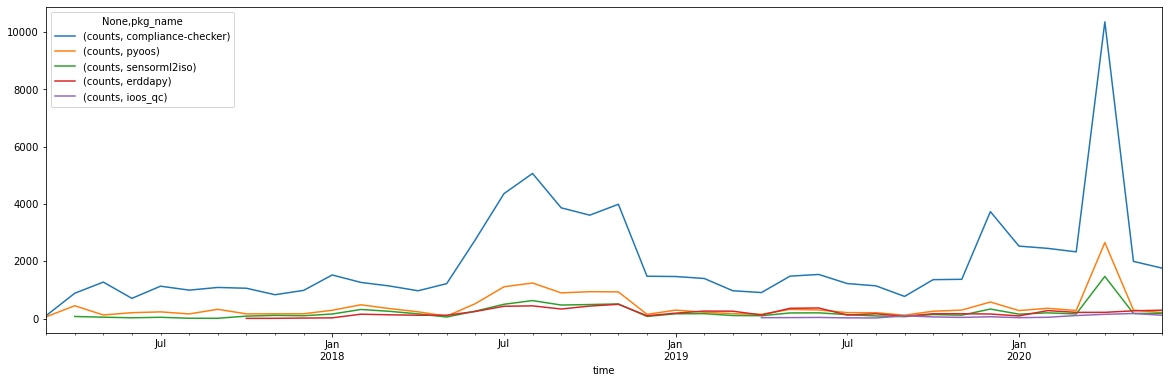

In [153]:
df.unstack(level=0).plot(kind='line', figsize=(20, 6));

It looks like Compliance Checker overall has a much higher download count than the other packages.  If we filter it out, we might see a more interesting plot.  

Also, there seems to be a monthly bias for several months for at least several packages (April 2020, for example saw a spike in downloads for compliance-checker, pyoos, and sensorml2iso).  compliance-checker itself had over 10,000 downloads... what might have caused this?

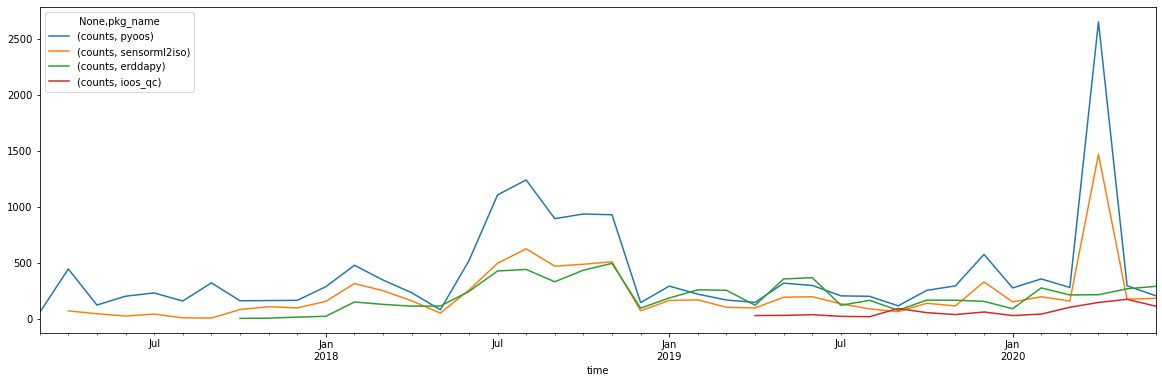

In [152]:
df.loc[['pyoos','sensorml2iso','erddapy','ioos_qc']].unstack(level=0).plot(kind='line', figsize=(20, 6));

Ok, that's not really very interesting.  The only trend readily apparent is that ioos_qc is increasing in download count from its first release in 2019 into 2020.  And maybe erddapy is getting a little more popular as well.

Let's aggregate by year, make a bar plot, and call it done.

In [278]:
df_unstack.resample('Y', level=0).sum().columns

MultiIndex([('counts', 'compliance-checker'),
            ('counts',              'pyoos'),
            ('counts',       'sensorml2iso'),
            ('counts',            'erddapy'),
            ('counts',            'ioos_qc')],
           names=[None, 'pkg_name'])

In [228]:
df_unstack.resample('Y', level=0).sum().columns.droplevel(0)

CategoricalIndex(['compliance-checker', 'pyoos', 'sensorml2iso', 'erddapy',
                  'ioos_qc'],
                 categories=['7za', '_license', '_nb_ext_conf', '_windows', 'abstract-rendering', 'accelerate', 'accelerate_cudalib', 'affine', ...], ordered=False, name='pkg_name', dtype='category')

Use .droplevel() to remove the 'counts' MultiIndex from the columns:

In [279]:
df_years = df_unstack.resample('Y', level=0).sum()
df_years.columns = df_years.columns.droplevel()
df_years

pkg_name    compliance-checker   pyoos  sensorml2iso  erddapy  ioos_qc
time                                                                  
2017-12-31              9051.0  2057.0         514.0     34.0      0.0
2018-12-31             31243.0  7229.0        3885.0   3032.0      0.0
2019-12-31             17376.0  3123.0        1830.0   2431.0    411.0
2020-12-31             21432.0  4082.0        2351.0   1370.0    625.0

In [280]:
df_years.index.get_level_values(0)

DatetimeIndex(['2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31'], dtype='datetime64[ns]', name='time', freq='A-DEC')

In [281]:
df_years.index

DatetimeIndex(['2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31'], dtype='datetime64[ns]', name='time', freq='A-DEC')

In [303]:
df_years.index.min()

Timestamp('2017-12-31 00:00:00', freq='A-DEC')

In [304]:
df_years.index.max()

Timestamp('2020-12-31 00:00:00', freq='A-DEC')

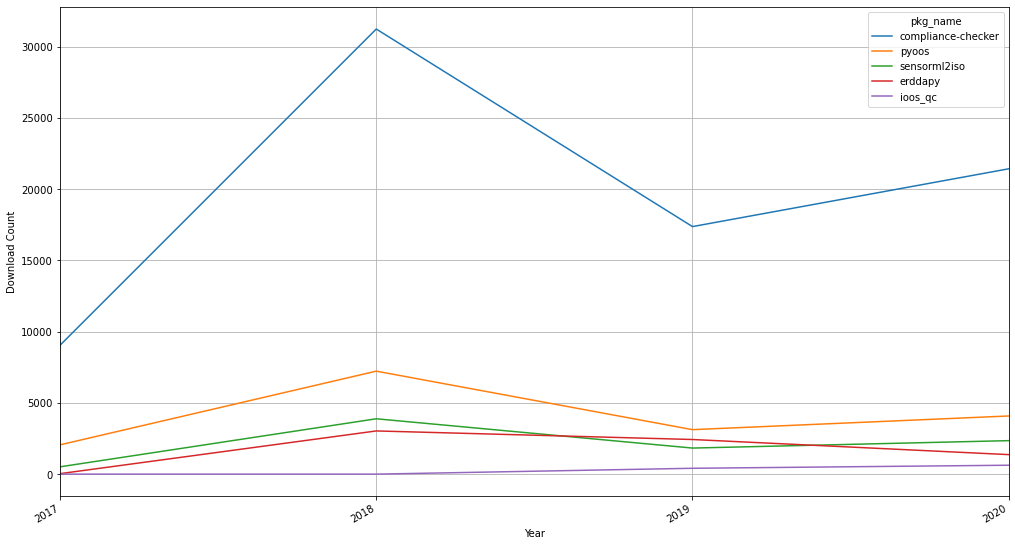

In [301]:
fig, ax = plt.subplots(figsize=(17, 10))

#df_years.plot(kind='bar', ax=ax, xlabel='Year', ylabel='Download Count', grid=True)
#df_years.plot(kind='bar', ax=ax, xticks=df_years.index, xlim=(df_years.index.min(), df_years.index.max()), grid=True)
#df_years.plot(kind='line', ax=ax, xticks=df_years.index, grid=True)
df_years.plot(kind='line', ax=ax, grid=True)
#ax.plot(df_years.index, df_years.values)

ax.set(xlabel='Year', ylabel='Download Count', xlim=(df_years.index.min(), df_years.index.max()))

#ax.set_xticks(df_years.index)
#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis_date()

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax.legend()

fig.autofmt_xdate()
#plt.show()

#df_unstack.resample('Y', level=0).sum().plot(kind='bar', xticks=df_unstack.resample('Y').sum().index.get_level_values(0), ax=ax);

#plt.gcf().autofmt_xdate()


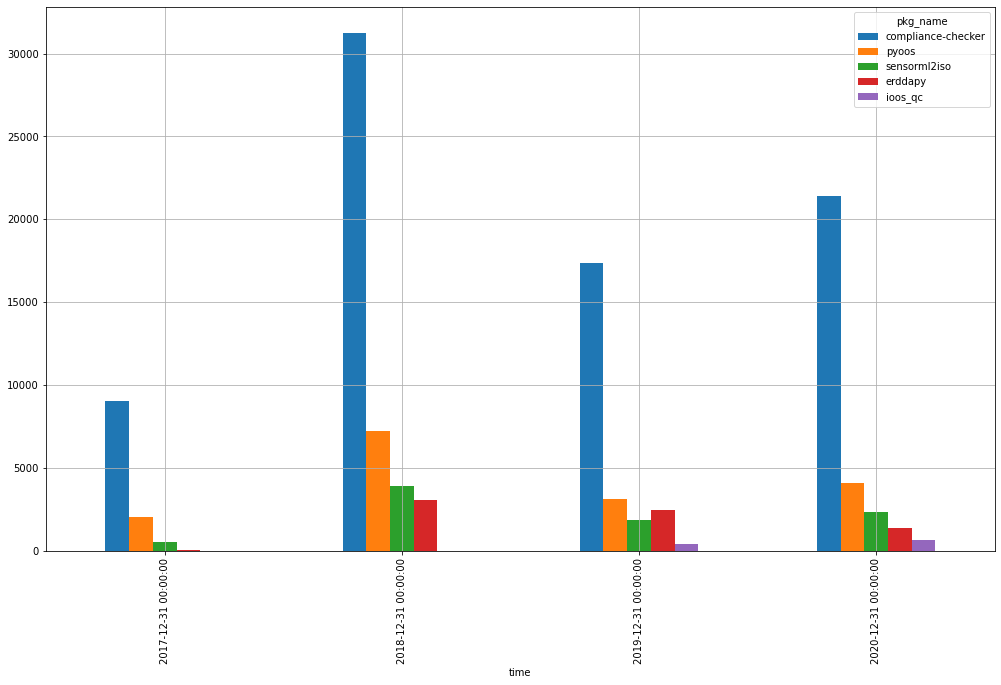

In [312]:
df_years.plot(kind='bar', figsize=(17, 10), grid=True );

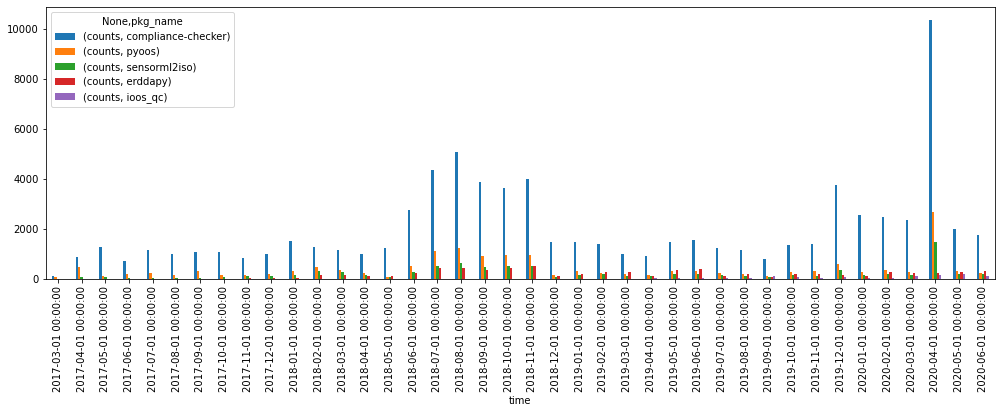

In [302]:

df.unstack(level=0).plot(kind='bar', figsize=(17, 5));

### df_recent:

This approach will return a proper slice from the level = 'time' index.  Assign to a new DataFrame 'df_recent' to plot.

In [313]:
df_recent = df.loc[df.index.get_level_values(level = 'time') >= '2018-01']

In [315]:
df_recent = df_recent.set_index([df_recent.index.get_level_values(level='pkg_name'), pd.to_datetime(df_recent.index.get_level_values(level='time'))])
df_recent

counts
pkg_name           time               
compliance-checker 2018-01-01   1523.0
                   2018-02-01   1263.0
                   2018-03-01   1138.0
                   2018-04-01    971.0
                   2018-05-01   1220.0
                   2018-06-01   2752.0
                   2018-07-01   4360.0
                   2018-08-01   5068.0
                   2018-09-01   3868.0
                   2018-10-01   3611.0
                   2018-11-01   3991.0
                   2018-12-01   1478.0
                   2019-01-01   1469.0
                   2019-02-01   1400.0
                   2019-03-01    971.0
                   2019-04-01    909.0
                   2019-05-01   1482.0
                   2019-06-01   1541.0
                   2019-07-01   1223.0
                   2019-08-01   1143.0
                   2019-09-01    774.0
                   2019-10-01   1359.0
                   2019-11-01   1371.0
                   2019-12-01   3734.0
                   2020-01-01   2530.0
                   2020-02-01   2452.0
                   2020-03-01   2330.0
                   2020-04-01  10361.0
                   2020-05-01   1997.0
                   2020-06-01   1762.0
pyoos              2018-01-01    290.0
                   2018-02-01    481.0
                   2018-03-01    349.0
                   2018-04-01    236.0
                   2018-05-01     84.0
                   2018-06-01    521.0
                   2018-07-01   1109.0
                   2018-08-01   1243.0
                   2018-09-01    897.0
                   2018-10-01    939.0
                   2018-11-01    932.0
                   2018-12-01    148.0
                   2019-01-01    295.0
                   2019-02-01    223.0
                   2019-03-01    171.0
                   2019-04-01    149.0
                   2019-05-01    321.0
                   2019-06-01    301.0
                   2019-07-01    208.0
                   2019-08-01    204.0
                   2019-09-01    119.0
                   2019-10-01    257.0
                   2019-11-01    297.0
                   2019-12-01    578.0
                   2020-01-01    279.0
                   2020-02-01    359.0
                   2020-03-01    283.0
                   2020-04-01   2654.0
                   2020-05-01    298.0
                   2020-06-01    209.0
sensorml2iso       2018-01-01    159.0
                   2018-02-01    318.0
                   2018-03-01    254.0
                   2018-04-01    164.0
                   2018-05-01     54.0
                   2018-06-01    259.0
                   2018-07-01    499.0
                   2018-08-01    628.0
                   2018-09-01    473.0
                   2018-10-01    490.0
                   2018-11-01    512.0
                   2018-12-01     75.0
                   2019-01-01    167.0
                   2019-02-01    172.0
                   2019-03-01    106.0
                   2019-04-01    100.0
                   2019-05-01    196.0
                   2019-06-01    200.0
                   2019-07-01    137.0
                   2019-08-01     92.0
                   2019-09-01     67.0
                   2019-10-01    142.0
                   2019-11-01    118.0
                   2019-12-01    333.0
                   2020-01-01    154.0
                   2020-02-01    200.0
                   2020-03-01    161.0
                   2020-04-01   1472.0
                   2020-05-01    178.0
                   2020-06-01    186.0
erddapy            2018-01-01     26.0
                   2018-02-01    153.0
                   2018-03-01    132.0
                   2018-04-01    116.0
                   2018-05-01    117.0
                   2018-06-01    247.0
                   2018-07-01    430.0
                   2018-08-01    444.0
                   2018-09-01    334.0
                   2018-10-01    437.0
                   2018-11-01    498.0
               

In [ ]:
#df_recent.resample('Y', level=1).unstack(level=0)
#df_recent.unstack(level=0).set_index('time').resample('Y').sum()

## Pandas Index debugging:

(just some debug output to properly filter the MultiIndex)

In [127]:
#df.index.get_level_values(0)
df.index.get_level_values(1)

DatetimeIndex(['2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='time', length=167, freq=None)

This returns all rows (no slice applied on the level=1 or 'time' index)

In [133]:
df.loc[slice(None), slice('2019-01', None)].head(15)

counts
pkg_name           time              
compliance-checker 2017-03-01   100.0
                   2017-04-01   884.0
                   2017-05-01  1274.0
                   2017-06-01   706.0
                   2017-07-01  1131.0
                   2017-08-01   993.0
                   2017-09-01  1087.0
                   2017-10-01  1059.0
                   2017-11-01   833.0
                   2017-12-01   984.0
                   2018-01-01  1523.0
                   2018-02-01  1263.0
                   2018-03-01  1138.0
                   2018-04-01   971.0
                   2018-05-01  1220.0

In [135]:
idx = pd.IndexSlice
df.loc[idx[:,['2019-01':]],:]
#df.loc[idx[:,['2019-01','2020-01']],:]

SyntaxError: invalid syntax (<ipython-input-135-9d37ac7578a5>, line 2)